In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ref_FOPT_df = pd.read_csv('Y-FOPT-ref.csv',header=None)
ref_FOPT_np = ref_FOPT_df.to_numpy()
ref_FOPT_np = ref_FOPT_np[:,0]

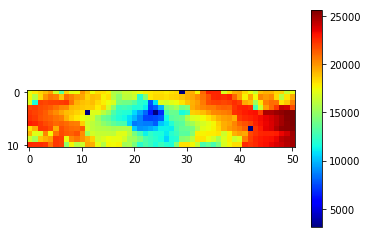

In [2]:
reference_production = ref_FOPT_np.reshape((11,51),order='F')
plt.imshow(reference_production,cmap='jet')
plt.colorbar()
#plt.show()

In [3]:
porosity_df = pd.read_csv('X-poro-ref.csv',header=None)
porosity_np = porosity_df.to_numpy()
porosity_np = porosity_np[:,0:125]
porosity_list = []
for i in range(561):
    new_data_infil = np.zeros((5,5,5))
    new_data_infil = np.reshape(porosity_np[i,:],(5,5,5))
    porosity_list.append(new_data_infil)

In [4]:
saturation_df = pd.read_csv('X-saturation-ref.csv',header=None)
saturation_np = saturation_df.to_numpy()
saturation_np = saturation_np[:,0:125]
saturation_list = []
for i in range(561):
    new_data_infil = np.zeros((5,5,5))
    new_data_infil = np.reshape(saturation_np[i,:],(5,5,5))
    saturation_list.append(new_data_infil)

In [5]:
pressure_df = pd.read_csv('X-pressure-ref.csv',header=None)
pressure_np = pressure_df.to_numpy()
pressure_np = pressure_np[:,0:125]
pressure_list = []
for i in range(561):
    new_data_infil = np.zeros((5,5,5))
    new_data_infil = np.reshape(pressure_np[i,:],(5,5,5))
    pressure_list.append(new_data_infil)

In [6]:
permeability_df = pd.read_csv('X-perm-ref.csv',header=None)
permeability_np = permeability_df.to_numpy()
permeability_np_x = permeability_np[0:561,0:125]
permeability_np_y = permeability_np[561:1122,0:125]
permeability_np_z = permeability_np[1122:1683,0:125]
permeability_np = (permeability_np_x+permeability_np_y+permeability_np_z)/3.0
permeability_list = []
for i in range(561):
    new_data_infil = np.zeros((5,5,5))
    new_data_infil = np.reshape(permeability_np[i,:],(5,5,5))
    permeability_list.append(new_data_infil)

In [7]:
auxiliary_df = pd.read_csv('X-auxilary-ref.csv',header=None)
auxiliary_np = auxiliary_df.to_numpy()
auxiliary_np = auxiliary_np[:,0:5]
auxiliary_list = []
for i in range(561):
    auxiliary_list.append(auxiliary_np[i,:])

In [10]:
### (1): Data
testing_X_perm = np.array(permeability_list)
testing_X_poro = np.array(porosity_list)
testing_X_satu = np.array(saturation_list)
testing_X_pres = np.array(pressure_list)
testing_X_auxu = np.array(auxiliary_list)

In [12]:
### Format Channels for CNN Networks
testing_X_perm = np.expand_dims(testing_X_perm, axis=1)
testing_X_poro = np.expand_dims(testing_X_poro, axis=1)
testing_X_satu = np.expand_dims(testing_X_satu, axis=1)
testing_X_pres = np.expand_dims(testing_X_pres, axis=1)

pt_testing_X_perm = Variable(torch.from_numpy(testing_X_perm).float(), requires_grad=False).to(device)
pt_testing_X_poro = Variable(torch.from_numpy(testing_X_poro).float(), requires_grad=False).to(device)
pt_testing_X_satu = Variable(torch.from_numpy(testing_X_satu).float(), requires_grad=False).to(device)
pt_testing_X_pres = Variable(torch.from_numpy(testing_X_pres).float(), requires_grad=False).to(device)
pt_testing_X_auxu = Variable(torch.from_numpy(testing_X_auxu).float(), requires_grad=False).to(device)


In [9]:
class CNN100(nn.Module):
    def __init__(self):
        super(CNN100, self).__init__()
        self.conv1 = torch.nn.Conv3d(in_channels=1, out_channels=100, kernel_size=[2,2,2], stride=1, padding=0)
        self.conv2 = torch.nn.Conv3d(in_channels=100, out_channels=100, kernel_size=[2,2,2], stride=1, padding=0)
        self.conv3 = torch.nn.Conv3d(in_channels=100, out_channels=100, kernel_size=[2,2,2], stride=1, padding=0)
        self.batchnorm = torch.nn.BatchNorm3d(num_features=1)

    def forward(self, x):
        norm_x = self.batchnorm(x)
        conv1_out = torch.nn.functional.relu(self.conv1(norm_x))
        conv2_out = torch.nn.functional.relu(self.conv2(conv1_out))
        conv3_out = torch.nn.functional.relu(self.conv3(conv2_out))
        flat_out = conv3_out.reshape(conv3_out.shape[0],-1)
        return flat_out

class CNN20(nn.Module):
    def __init__(self):
        super(CNN20, self).__init__()
        self.conv1 = torch.nn.Conv3d(in_channels=1, out_channels=20, kernel_size=[2,2,2], stride=1, padding=0)
        self.conv2 = torch.nn.Conv3d(in_channels=20, out_channels=20, kernel_size=[2,2,2], stride=1, padding=0)
        self.conv3 = torch.nn.Conv3d(in_channels=20, out_channels=20, kernel_size=[2,2,2], stride=1, padding=0)
        self.batchnorm = torch.nn.BatchNorm3d(num_features=1)

    def forward(self, x):
        norm_x = self.batchnorm(x)
        conv1_out = torch.nn.functional.relu(self.conv1(norm_x))
        conv2_out = torch.nn.functional.relu(self.conv2(conv1_out))
        conv3_out = torch.nn.functional.relu(self.conv3(conv2_out))
        flat_out = conv3_out.reshape(conv3_out.shape[0],-1)
        return flat_out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.perm_cnn = CNN100()
        self.poro_cnn = CNN100()
        self.satu_cnn = CNN20()
        self.pres_cnn = CNN20()
        self.batchnorm = torch.nn.BatchNorm1d(num_features=1925)
        
        self.lin1 = torch.nn.Linear(in_features=1925, out_features=500)
        self.lin2 = torch.nn.Linear(in_features=500, out_features=100)
        self.lin3 = torch.nn.Linear(in_features=100, out_features=30)
        self.ouput = torch.nn.Linear(in_features=30, out_features=1)
    def forward(self, Xperm, Xporo, Xsatu, Xpres, Xauxu):
        poro_out = self.poro_cnn(Xporo)
        perm_out = self.perm_cnn(Xperm)
        satu_out = self.satu_cnn(Xsatu)
        pres_out = self.pres_cnn(Xpres)
        #Concatenation
        con_out = torch.cat([perm_out,poro_out,satu_out,pres_out,Xauxu],1)
        con_out_norm = self.batchnorm(con_out)
        lin1_out = torch.nn.functional.relu(self.lin1(con_out_norm))
        lin2_out = torch.nn.functional.relu(self.lin2(lin1_out))
        lin3_out = torch.nn.functional.relu(self.lin3(lin2_out))
        fopt = self.ouput(lin3_out)  
        return fopt

In [11]:
### (2) Model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net.load_state_dict(torch.load("my_model.pt"))
net.eval()
net = net.to(device)
cost_function = torch.nn.MSELoss() # Mean squared error

In [13]:
cnn_FOPT_np = net(pt_testing_X_perm,pt_testing_X_poro,pt_testing_X_satu,pt_testing_X_pres,pt_testing_X_auxu).data.cpu().numpy().flatten()*100000.0

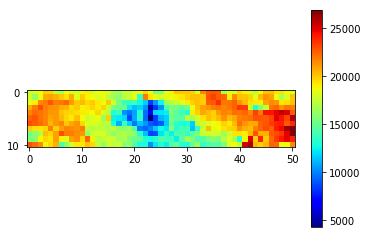

In [19]:
cnn_production = cnn_FOPT_np.reshape((11,51),order='F')/10.0
plt.imshow(cnn_production,cmap='jet')
plt.colorbar()

In [17]:
np.unravel_index(np.argmax(cnn_production),cnn_production.shape)

(8, 50)

In [18]:
np.unravel_index(np.argmax(reference_production),reference_production.shape)

(4, 50)

In [20]:
reference_production[4,50]

25617.0

In [21]:
cnn_production[8,50]

26851.8

In [22]:
cnn_production[4,50]

22596.994

In [23]:
reference_production[8,50]

24917.1

In [24]:
np.sqrt(np.linalg.norm(cnn_production-reference_production,'fro'))

217.58579483174725

In [25]:
np.mean(cnn_production-reference_production)

345.9903979709781

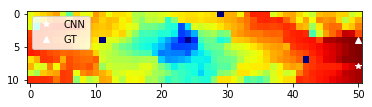

In [35]:
plt.imshow(reference_production,cmap='jet')
plt.plot([50],[8],'*w',label='CNN')
plt.plot([50],[4],'^w',label='GT')
plt.legend(bbox_to_anchor=(0,1), loc='upper left', ncol=1)
#plt.colorbar()